# Fraud Detection Appled Machine Learning

### Context
It is important that credit card companies are able to recognize fraudulent credit card transactions so that customers are not charged for items that they did not purchase.

### Content
The datasets contains transactions made by credit cards in September 2013 by european cardholders. This dataset presents transactions that occurred in two days, where we have 492 frauds out of 284,807 transactions. The dataset is highly unbalanced, the positive class (frauds) account for 0.172% of all transactions.

It contains only numerical input variables which are the result of a PCA transformation. Unfortunately, due to confidentiality issues, the original features and more background information about the data could not be provided. Features V1, V2, ... V28 are the principal components obtained with PCA, the only features which have not been transformed with PCA are 'Time' and 'Amount'. Feature 'Time' contains the seconds elapsed between each transaction and the first transaction in the dataset. The feature 'Amount' is the transaction Amount, this feature can be used for example-dependant cost-senstive learning. Feature 'Class' is the response variable and it takes value 1 in case of fraud and 0 otherwise.

### Model Evaluation Metrics Used 

##### Accuracy 
Is the most intuitive performance measure and it is simply a ratio of correctly predicted observation to the total observations. One may think that, if we have high accuracy then our model is best. Yes, accuracy is a great measure but only when you have symmetric datasets where values of false positive and false negatives are almost same. Therefore, we have to look at other parameters to evaluate the performance of our model. 

###### Precision 
Is the ratio of correctly predicted positive observations to the total predicted positive observations. The question that this metric answers is: Of all transactions that were labeled as fraud, how many were actually fraud? 

Precision = TP/TP+FP

##### Recall (Sensitivity) 
Is the ratio of correctly predicted positive observations to the all observations in actual class - yes. The question recall answers is: Of all the transaction that where truly fraudulent, how many did the model label correctly? 

Recall = TP/TP+FN

##### Area Under the Precision-Recall Curve (AUPRC)

https://www.biostat.wisc.edu/~page/rocpr.pdf

In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed

import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import recall_score,accuracy_score, classification_report,precision_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
 
import warnings
warnings.filterwarnings('ignore')

# Collect The Data 

In [3]:
## Read the data
df = pd.read_csv("../data/creditcard.csv")
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


# Full Sampled Data

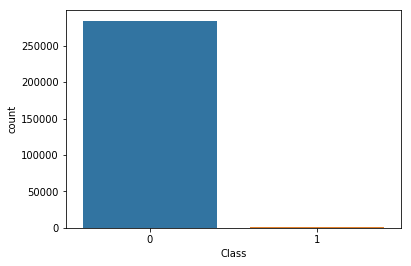

In [4]:
## Plot the distribution of data
%matplotlib inline
sns.countplot(x='Class', data=df)

From the above graph you can observe that data is really skewed for class 0 which indicates the non fradulant transactions.

#### Train/Test Split  

Inmportant Note: We should never balance the entire data set using SMOTE or other Up/Down-Sampling techniques before splitting the data into test and train. Doing so we would leak the information in the test data set into training data set. This messes up generalization of the model. Instead we need to split the data first and then use SMOTE or any up/down-sampling method. This eliminates leaking the information from test set into the training set.

In [5]:
df['normal_amount'] = StandardScaler().fit_transform(df['Amount'].values.reshape(-1,1))
df = df.drop(['Amount','Time'], axis=1)
X = df.loc[:,df.columns != 'Class']
y = df.loc[:,df.columns == 'Class']
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = 0.3, random_state = 0)

The code below trains a Random Forest model on original data. As you can observe from the output, recall is pretty poor. But accuracy is pretty high.

#### Base Line Modeling 

In [6]:
# Calculate the recall score for logistic Regression on Skewed data
rf = RandomForestClassifier(n_estimators=5, random_state=12)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)
print(accuracy_score(y_test,y_pred))
print(recall_score(y_test,y_pred))
print(precision_score(y_test,y_pred))

0.9994382219725431
0.7414965986394558
0.9159663865546218


#### Area Under the Precision-Recall Curve (AUPRC)

Text(0.5,1,'2-class Precision-Recall curve: AP=0.68')

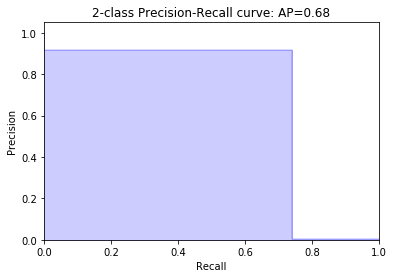

In [7]:
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt
from sklearn.utils.fixes import signature
from sklearn.metrics import average_precision_score

average_precision = average_precision_score(y_test, y_pred)

precision, recall, _ = precision_recall_curve(y_test, y_pred)

# In matplotlib < 1.5, plt.fill_between does not have a 'step' argument
step_kwargs = ({'step': 'post'}
               if 'step' in signature(plt.fill_between).parameters
               else {})
plt.step(recall, precision, color='b', alpha=0.2,
         where='post')
plt.fill_between(recall, precision, alpha=0.2, color='b', **step_kwargs)

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('2-class Precision-Recall curve: AP={0:0.2f}'.format(
          average_precision))

##### Randomized Grid Search 

In [ ]:
from pprint import pprint

# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]

# Number of features to consider at every split
max_features = ['auto', 'sqrt']

# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)

# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]

# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]

# Method of selecting samples for training each tree
bootstrap = [True, False]

# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap
}

params = { 'bootstrap': [True, False],
            'max_depth': [10, 20, 30, 40, None],
            'max_features': ['auto', 'sqrt'],
            'min_samples_leaf': [1, 2, 4],
            'min_samples_split': [2, 5, 10],
            'n_estimators': [200, 400]
}

pprint(params)

In [ ]:
# Use the random grid to search for best hyperparameters
# First create the base model to tune
rf = RandomForestClassifier()

# Rearch of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
#clf = GridSearchCV(estimator=rf, param_grid=random_grid, n_jobs=-1)

# Fit the random search model
#clf.fit(X_train, y_train)

# Under Sampled Data

To improve the recall, let's implement undersampling. Here the code is trying to reduce the number of non fraudulent transactions equivalent to fraudulent ones. The way we will under sample the dataset will be by creating a 50/50 ratio. This will be done by randomly selecting "x" amount of sample from the majority class, being "x" the total number of records with the minority class.

In [8]:
# Undersample the data
no_frauds = len(df[df['Class'] == 1])
non_fraud_indices = df[df.Class == 0].index
random_indices = np.random.choice(non_fraud_indices,no_frauds, replace=False)
fraud_indices = df[df.Class == 1].index
under_sample_indices = np.concatenate([fraud_indices,random_indices])
under_sample = df.loc[under_sample_indices]

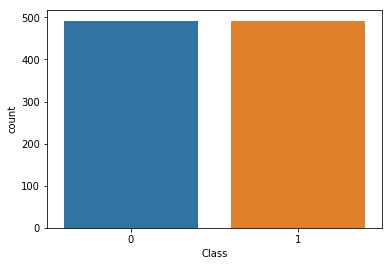

In [9]:
## Plot the distribution of data for undersampling
%matplotlib inline
sns.countplot(x='Class', data=under_sample)

In [10]:
X_under = under_sample.loc[:,under_sample.columns != 'Class']
y_under = under_sample.loc[:,under_sample.columns == 'Class']
X_under_train, X_under_test, y_under_train, y_under_test = train_test_split(X_under,y_under,test_size = 0.3, random_state = 0)

Below code trains the logistic regression on undersampled data. From the result, you can observe that the recall is much better.

In [11]:
rf_under = RandomForestClassifier(n_estimators=25, random_state=12)
rf_under.fit(X_under_train,y_under_train)
y_under_pred = rf_under.predict(X_under_test)
print(accuracy_score(y_under_test,y_under_pred))
print(recall_score(y_under_test,y_under_pred))
print(precision_score(y_under_test,y_under_pred))

0.9425675675675675
0.9387755102040817
0.9452054794520548


Text(0.5,1,'2-class Precision-Recall curve: AP=0.92')

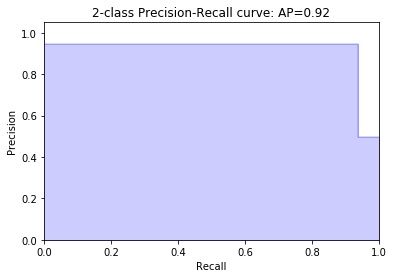

In [12]:
average_precision_under = average_precision_score(y_under_test,y_under_pred)

precision, recall, _ = precision_recall_curve(y_under_test,y_under_pred)

# In matplotlib < 1.5, plt.fill_between does not have a 'step' argument
step_kwargs = ({'step': 'post'}
               if 'step' in signature(plt.fill_between).parameters
               else {})
plt.step(recall, precision, color='b', alpha=0.2,
         where='post')
plt.fill_between(recall, precision, alpha=0.2, color='b', **step_kwargs)

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('2-class Precision-Recall curve: AP={0:0.2f}'.format(
          average_precision_under))

###### Generalization 

It also generalises good enough for full data. With only recall and accuracy used as the metrics to evaluate the model's performance. 

In [13]:
## Recall for the full data
y_pred_full = rf_under.predict(X_test)
print(accuracy_score(y_test,y_pred_full))
print(recall_score(y_test,y_pred_full))
print(precision_score(y_test, y_pred_full))

0.9564504991631848
0.9727891156462585
0.03704663212435233


###### Area Under the Precision-Recall Curve (AUPRC)
Here we test how well the model generalized over the entire data set. 

Text(0.5,1,'2-class Precision-Recall curve: AP=0.04')

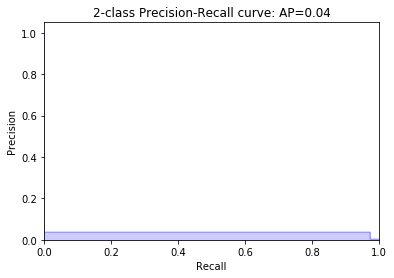

In [14]:
average_precision_under_general = average_precision_score(y_test,y_pred_full)

precision, recall, _ = precision_recall_curve(y_test,y_pred_full)

# In matplotlib < 1.5, plt.fill_between does not have a 'step' argument
step_kwargs = ({'step': 'post'}
               if 'step' in signature(plt.fill_between).parameters
               else {})
plt.step(recall, precision, color='b', alpha=0.2,
         where='post')
plt.fill_between(recall, precision, alpha=0.2, color='b', **step_kwargs)

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('2-class Precision-Recall curve: AP={0:0.2f}'.format(
          average_precision_under_general))

# SMOTE (Synthetic Minority Over-Sampling Technique)
This method of over-sampling the minority class involves creating synthetic minority class examples, and training the model on the new data set. 

https://arxiv.org/pdf/1106.1813.pdf

In [15]:
sm = SMOTE(random_state=12, ratio = 1.0)
x_train_res, y_train_res = sm.fit_sample(X_train, y_train)

In [16]:
clf_rf_sm = RandomForestClassifier(n_estimators=25, random_state=0)
clf_rf_sm.fit(x_train_res, y_train_res)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=25, n_jobs=None,
            oob_score=False, random_state=0, verbose=0, warm_start=False)

In [17]:
y_pred_smote = clf_rf_sm.predict(X_test)

In [18]:
print('Validation Results')
print(clf_rf_sm.score(X_test, y_test))
print(recall_score(y_test, y_pred_smote))
print(precision_score(y_test, y_pred_smote))

Validation Results
0.9995201479348805
0.8027210884353742
0.9076923076923077


Text(0.5,1,'2-class Precision-Recall curve: AP=0.73')

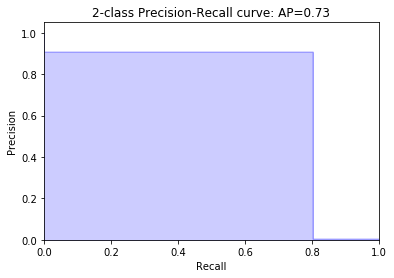

In [19]:
average_precision_smote = average_precision_score(y_test,y_pred_smote)

precision, recall, _ = precision_recall_curve(y_test,y_pred_smote)

# In matplotlib < 1.5, plt.fill_between does not have a 'step' argument
step_kwargs = ({'step': 'post'}
               if 'step' in signature(plt.fill_between).parameters
               else {})
plt.step(recall, precision, color='b', alpha=0.2,
         where='post')
plt.fill_between(recall, precision, alpha=0.2, color='b', **step_kwargs)

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('2-class Precision-Recall curve: AP={0:0.2f}'.format(
          average_precision_smote))

# Conclusion 

Because positive is the minority class. There are a lot of negative examples that could become false positives. Conversely, there are fewer positive examples that could become false negatives.

Sensitivity (True Positive Rate) is related to False Positive Rate (1-specificity) as visualized by an ROC curve. At one extreme, you call every example positive and have a 100% sensitivity with 100% FPR. At another, you call no example positive and have a 0% sensitivity with a 0% FPR. When the positive class is the minority, even a relatively small FPR (which you may have because you have a high recall=sensitivity=TPR) will end up causing a high number of FPs (because there are so many negative examples).

It might be the case that even though the classifier has low precision, it could lead to a very useful probability estimate. For example, just knowing that a hard drive might have a 500 fold increased probability of failing, even though the absolute probability is fairly small, might be important information.

Also, a low precision essentially means that the classifier returns a lot of false positives. This however might not be so bad if a false positive is cheap.

We are very interested in the recall score, because that is the metric that will help us try to capture the most fraudulent transactions. If you think how Accuracy, Precision and Recall work for a confusion matrix, recall would be the most interesting. 